# Notebook to group FORS2-SL SED's around that from Kinney-Calzetti and select a subset as SED templates for LePhare

## Exclude some FORS2-Starlight spectra because they end up generating outliers.

Created on : Apr. 2, 2023 by Joseph Chevalier

In [1]:
import os, sys, re
import pickle
import json
import glob
import collections
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.offsetbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

from itertools import cycle, islice

from astropy.io import fits
from astropy.table import Table
from scipy import ndimage
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans


# Import the primary photometry classes from rubin_sim.photUtils
from rubin_sim.phot_utils import Bandpass
from rubin_sim.phot_utils import Sed
from rubin_sim.data import get_data_dir
from StudyFors2SED.def_raw_seds import *
#from StudyFors2SED.raw_data_analysis import *

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/home/joseph/local/dir/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/home/joseph/local/dir/trds/mtab/6452249tm_tmc.fits',
 'thermtable': '/home/joseph/local/dir/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [2]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

In [3]:
root_dir, base_name = os.path.split(os.getcwd())
print(root_dir)

/home/joseph


In [4]:
filename_fits_catalog
t = Table.read(filename_fits_catalog)
t[t["ID"]==106]['z'][0]

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/astropy/io/fits/connect.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


0.6436

In [5]:
print(path_BC)
spec_list = sorted(os.listdir(path_BC))
#print(spec_list)

/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/conf1/HZ4/output_rebuild_BC/full_spectra/


In [6]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in spec_list ]
all_numbers = sorted(all_numbers)
#all_numbers

## 1- Clustering around the 12 Kinney-Calzetti SEDs
Expermient alternate method vs. Kmean clustering

In [7]:
_l1 = np.arange(100., 1000., 10)
_l2 = np.arange(1000., 11000., 1)
_l3 = np.arange(11000., 100000., 50)
lambdas = np.append(_l1, np.append(_l2, _l3))
#print(len(lambdas))

lambdaMin, lambdaMax = 0., 10000.

mask = (lambdas >= lambdaMin)*(lambdas <= lambdaMax)

mag_list = ['U', 'B', 'V', 'R', 'I']
l1m, l2m, l1p, l2p = 3850, 3950, 4050, 4100

In [8]:
def dist_spec(spec_arr, refSpec_arr, lambdas, KL_div=False, lambda_min=lambdaMin, lambda_max=lambdaMax, lambda_step=10.):
    mask = (lambdas>=lambda_min) * (lambdas<=lambda_max)
    if KL_div:
        warnings.warn("KL-divergence is used. Please check that spectra in use have been normalized by their integral between lambda_min and lambda_max and thus can be treated as probability distributions.", UserWarning)
        _diff = spec_arr[mask]*np.log(spec_arr[mask]/refSpec_arr[mask])
        dist = np.trapz(_diff, lambdas[mask])
    else:
        _diff = np.power(spec_arr[mask]-refSpec_arr[mask], 2.)
        dist = np.power(np.sum(_diff), 0.5)
    return dist

def dist_color(c1, c2, c3, c4, c1ref, c2ref, c3ref, c4ref):
    '''
    Computes the distance in a 4-dimensional color-space (U-B, B-V, V-R, R-I).
    Numpy-like : if inputs are scalar, returns a scalar.
    If 1D-arrays, they must have the same length and an array of distances is returned.
    Purpose : identify a closest neighbor among references in color-space.
    '''
    _c1=np.asarray(c1)
    _c2=np.asarray(c2)
    _c3=np.asarray(c3)
    _c4=np.asarray(c4)
    
    _c1ref=np.asarray(c1ref)
    _c2ref=np.asarray(c2ref)
    _c3ref=np.asarray(c3ref)
    _c4ref=np.asarray(c4ref)
    _sum = np.power(_c1-_c1ref, 2.) + np.power(_c2-_c2ref, 2.) + np.power(_c3-_c3ref, 2.) + np.power(_c4-_c4ref, 2.)
    dists = np.power(_sum, 0.5)
    return dists

670.0
950.0
890.0
1390.0
1490.0


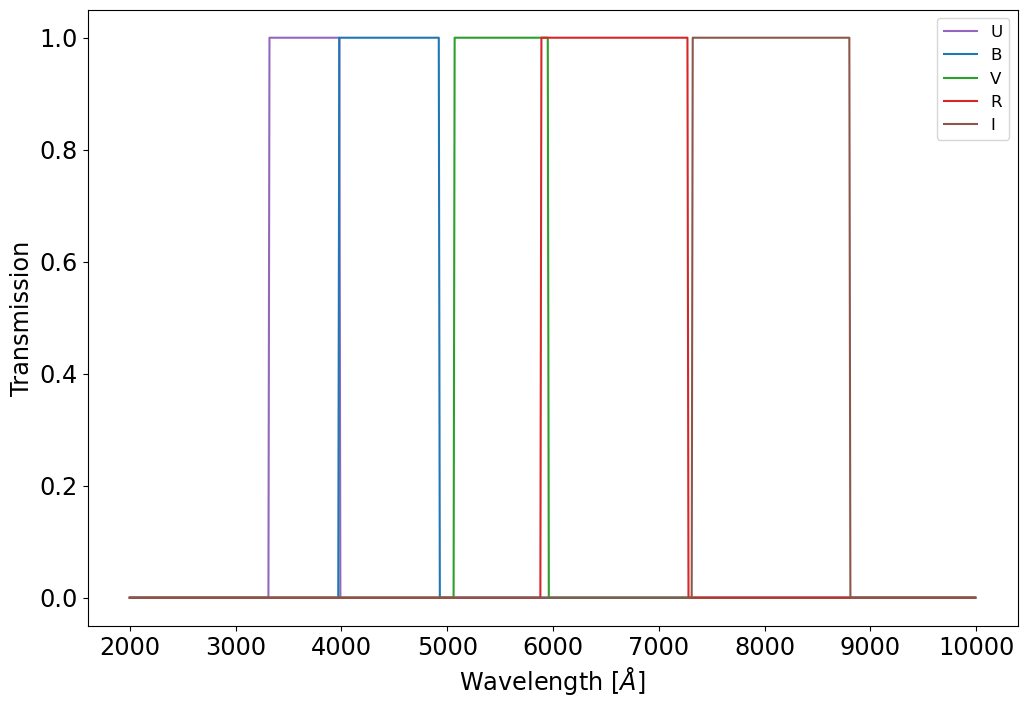

In [9]:
# mean WL (AA), full width at half maximum (AA), flux(lambda) for 0-magnitude (W/m²)
U_band_center, U_band_FWHM, U_band_f0 = 3650., 660., 3.981e-02
B_band_center, B_band_FWHM, B_band_f0 = 4450., 940., 6.310e-02
V_band_center, V_band_FWHM, V_band_f0 = 5510., 880., 3.631e-02
R_band_center, R_band_FWHM, R_band_f0 = 6580., 1380., 2.239e-02
I_band_center, I_band_FWHM, I_band_f0 = 8060., 1490., 1.148e-02

# FWHM = 2.sqrt(2.ln2).sigma for a normal distribution
U_band_sigma = U_band_FWHM/(2*np.sqrt(2*np.log(2)))
B_band_sigma = B_band_FWHM/(2*np.sqrt(2*np.log(2)))
V_band_sigma = V_band_FWHM/(2*np.sqrt(2*np.log(2)))
R_band_sigma = R_band_FWHM/(2*np.sqrt(2*np.log(2)))
I_band_sigma = I_band_FWHM/(2*np.sqrt(2*np.log(2)))

gauss_bands_dict = {\
                    "U":{"Mean": U_band_center,\
                         "Sigma": U_band_sigma,\
                         "f_0": U_band_f0\
                        },\
                    "B":{"Mean": B_band_center,\
                         "Sigma": B_band_sigma,\
                         "f_0": B_band_f0\
                        },\
                    "V":{"Mean": V_band_center,\
                         "Sigma": V_band_sigma,\
                         "f_0": V_band_f0\
                        },\
                    "R":{"Mean": R_band_center,\
                         "Sigma": R_band_sigma,\
                         "f_0": R_band_f0\
                        },\
                    "I":{"Mean": I_band_center,\
                         "Sigma": I_band_sigma,\
                         "f_0": I_band_f0\
                        }\
                   }

rect_bands_dict = {\
                   "U":{"Mean": U_band_center,\
                        "Width": U_band_FWHM,\
                        "f_0": U_band_f0\
                       },\
                   "B":{"Mean": B_band_center,\
                        "Width": B_band_FWHM,\
                        "f_0": B_band_f0\
                       },\
                   "V":{"Mean": V_band_center,\
                        "Width": V_band_FWHM,\
                        "f_0": V_band_f0\
                       },\
                   "R":{"Mean": R_band_center,\
                        "Width": R_band_FWHM,\
                        "f_0": R_band_f0\
                       },\
                   "I":{"Mean": I_band_center,\
                        "Width": I_band_FWHM,\
                        "f_0": I_band_f0\
                       }\
                  }

def gaussian_band(mu, sig, interp_step=1.):
    # Returns A FUNCTION that is created by 1D-interpolation of a normal distrib of mean mu and std dev sig
    # Interpolation range is defined arbitrarily as +/- 10sig
    # interpolation step is 1. (design case is we are working with angstrom units with a resolution of .1nm)
    _x = np.arange(mu-10*sig, mu+10*sig+interp_step, interp_step)
    _y = np.exp(-np.power(_x-mu, 2)/(2*np.power(sig, 2))) / (sig*np.power(2*np.pi, 0.5))
    _max = np.amax(_y)
    _y = _y/_max
    #_int = np.trapz(_y, _x)
    func = interp1d(_x, _y, bounds_error=False, fill_value=0.)
    return func

def rect_band(mu, width, interp_step=1.):
    # Returns A FUNCTION that is created by 1D-interpolation of a normal distrib of mean mu and std dev sig
    # Interpolation range is defined arbitrarily as +/- 10sig
    # interpolation step is 1. (design case is we are working with angstrom units with a resolution of .1nm)
    _x = np.arange(mu-width/2, mu+width/2+interp_step, interp_step)
    #_int = np.trapz(_y, _x)
    func = interp1d(_x, np.ones_like(_x), bounds_error=False, fill_value=0.)
    return func

def flux_in_band(wavelengths, spectrum, band_name, band_shape="window"):
    from astropy import constants as const
    if band_shape == "gaussian":
        _band = gaussian_band(band_name["Mean"], band_name["Sigma"])
    else:
        band_shape = "window"
        _band = rect_band(band_name["Mean"], band_name["Width"])
    _transm = spectrum * _band(wavelengths) # * ( const.c.value / np.power(wavelengths, 2) ) if flux-density is in f_nu(lambda) 
    flux = np.trapz(_transm, wavelengths)/(4*np.pi*(10.)**2) #(4*np.pi*(3.0857e17)**2) # DL=10pcs for absolute magnitudes
    return flux

def mag_in_band(wavelengths, spectrum, band_name):
    _flux = flux_in_band(wavelengths, spectrum, band_name)
    _mag0 = -2.5*np.log10(band_name["f_0"])
    mag = -2.5*np.log10(_flux) - _mag0
    return mag

def color_index(wavelengths, spectrum, band_1, band_2):
    _mag1 = mag_in_band(wavelengths, spectrum, band_1)
    _mag2 = mag_in_band(wavelengths, spectrum, band_2)
    color = _mag1 - _mag2
    return color

_wl = np.arange(2000., 10000., 10)

for _mu, _sig, _f0, c, l in zip([U_band_center, B_band_center, V_band_center, R_band_center, I_band_center],\
                                [U_band_sigma, B_band_sigma, V_band_sigma, R_band_sigma, I_band_sigma],\
                                [U_band_f0, B_band_f0, V_band_f0, R_band_f0, I_band_f0],\
                                ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:brown'],\
                                ['U', 'B', 'V', 'R', 'I']\
                               ):
    _band = rect_band(_mu, 2.355*_sig)
    _int = np.trapz(_band(_wl), _wl)
    plt.plot(_wl, _band(_wl), color=c, label=l)
    plt.xlabel("Wavelength [$\AA$]")
    plt.ylabel("Transmission")
    plt.legend()
    print(_int)

### Load CWW / Kinney-Calzetti SEDs from LEPHARE

In [10]:
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.getenv('LEPHAREDIR')
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(), "LEPHARE"))
print(LEPHAREDIR)
ref_seds = 'CWW_KINNEY'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', ref_seds)
print(sed_dir)

lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    LEPHAREWORK = os.environ['LEPHAREWORK']
else:
    LEPHAREWORK = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = LEPHAREWORK

/home/joseph/PhotoZ_PhD/LEPHARE
/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/CWW_KINNEY


In [11]:
fmt='.sed'
seds = []
for f in os.listdir(sed_dir):
    if fmt in f:
        seds.append(f)
print(seds)

['CWW_Sbc_ext.sed', 'KIN_SB2_ext.sed', 'KIN_SB3_ext.sed', 'KIN_SB6_ext.sed', 'KIN_SB5_ext.sed', 'KIN_SB4_ext.sed', 'CWW_E_ext.sed', 'CWW_Im_ext.sed', 'KIN_SB1_ext.sed', 'CWW_Scd_ext.sed', 'KIN_Sb_ext.sed', 'KIN_Sa_ext.sed']


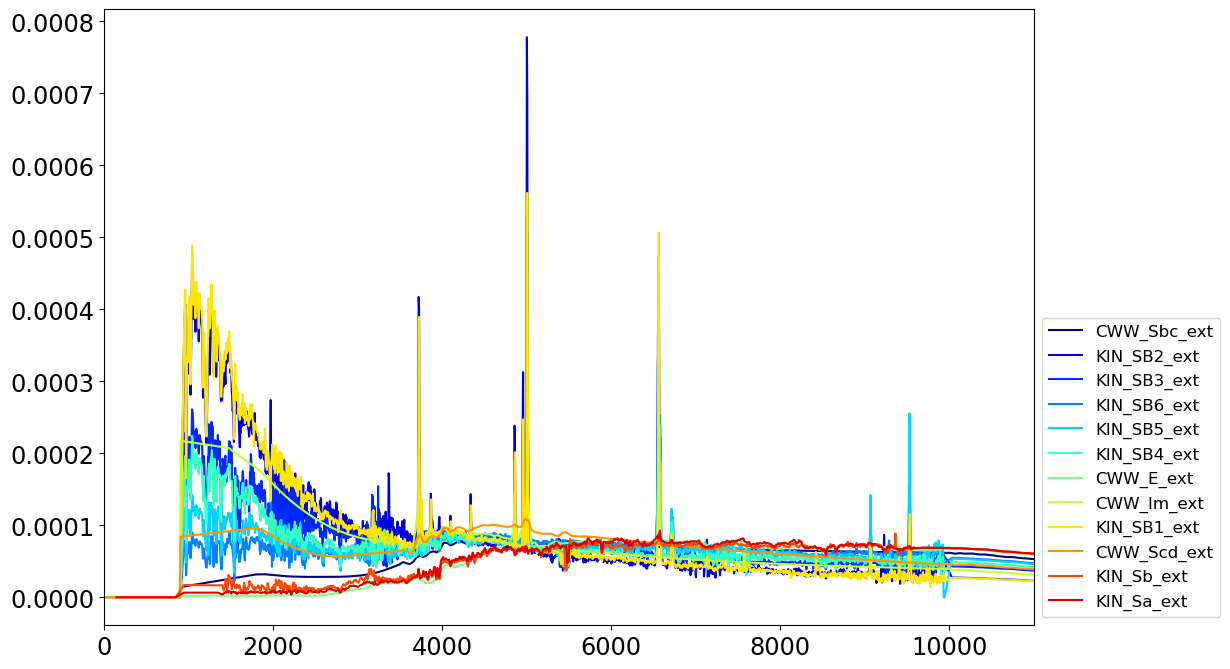

In [12]:
NrefSEDs=len(seds)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NrefSEDs)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors_refs = scalarMap.to_rgba(np.arange(NrefSEDs), alpha=1)

f, a = plt.subplots(1,1)
for sed, c in zip(seds, all_colors_refs):
    sed_arr = np.loadtxt(os.path.join(sed_dir, sed))
    _mask = (sed_arr[:,0] >= 1000.) * (sed_arr[:,1] <= 10000.)
    norm = np.trapz(sed_arr[:,1][_mask], sed_arr[:,0][_mask])
    a.plot(sed_arr[:, 0], sed_arr[:, 1]/norm, label=sed.split('.')[0], color=c)

a.set_xlim(0., 11000.)
#a.set_yscale('log')
a.legend(loc='lower left', bbox_to_anchor = (1., 0.))

In [13]:
df_cww_spec = pd.DataFrame()
df_cww_spec_normed = pd.DataFrame()
df_cww_spec['Wavelength'] = lambdas
df_cww_spec_normed['Wavelength'] = lambdas
for sed in seds:
    spec_path = os.path.join(sed_dir, sed)
    spec_arr = np.loadtxt(spec_path)
    spec_fonc = interp1d(spec_arr[:-1, 0], spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
    lumins = spec_fonc(lambdas)
    _norm = np.trapz(lumins[mask], lambdas[mask])
    normed_spec = lumins/_norm
    df_cww_spec[ sed.split('.')[0] ] = lumins
    df_cww_spec_normed[ f"{sed.split('.')[0]}_norm" ] = normed_spec
sorted(df_cww_spec_normed.keys())

['CWW_E_ext_norm',
 'CWW_Im_ext_norm',
 'CWW_Sbc_ext_norm',
 'CWW_Scd_ext_norm',
 'KIN_SB1_ext_norm',
 'KIN_SB2_ext_norm',
 'KIN_SB3_ext_norm',
 'KIN_SB4_ext_norm',
 'KIN_SB5_ext_norm',
 'KIN_SB6_ext_norm',
 'KIN_Sa_ext_norm',
 'KIN_Sb_ext_norm',
 'Wavelength']

### Load FORS2 SEDs from Starlight

This is where we filter out the non-desired spectra.

In [14]:
df_fors2SL_spec = pd.DataFrame()
df_fors2SL_spec_normed = pd.DataFrame()
df_fors2SL_spec['Wavelength'] = lambdas
df_fors2SL_spec_normed['Wavelength'] = lambdas
to_be_removed = {84, 89, 518, 210, 212, 267, 297, 346, 591, 722}
all_numbers = [ num for num in all_numbers if num not in to_be_removed ]
for _num in all_numbers:
    _path = os.path.join(path_BC, f'SPEC{_num}_HZ4_BC.txt')
    _arr = np.loadtxt(_path)
    _fonc = interp1d(_arr[:-1, 0], _arr[:-1, 1], bounds_error=False, fill_value=0.)
    lumins = _fonc(lambdas)
    _norm = np.trapz(lumins[mask], lambdas[mask])
    normed_spec = lumins/_norm
    
    _df_fors2SL_spec = df_fors2SL_spec.copy()
    _df_fors2SL_spec_normed = df_fors2SL_spec_normed.copy()
    _df_fors2SL_spec[ f'SPEC{_num}_HZ4_BC' ] = lumins
    _df_fors2SL_spec_normed[ f"SPEC{_num}_HZ4_BC_norm" ] = normed_spec
    df_fors2SL_spec = _df_fors2SL_spec.copy()
    df_fors2SL_spec_normed = _df_fors2SL_spec_normed.copy()
df_fors2SL_spec_normed

,Wavelength,SPEC2_HZ4_BC_norm,SPEC3_HZ4_BC_norm,SPEC9_HZ4_BC_norm,SPEC13_HZ4_BC_norm,SPEC19_HZ4_BC_norm,SPEC24_HZ4_BC_norm,SPEC25_HZ4_BC_norm,SPEC30_HZ4_BC_norm,SPEC31_HZ4_BC_norm,...,SPEC729_HZ4_BC_norm,SPEC730_HZ4_BC_norm,SPEC731_HZ4_BC_norm,SPEC732_HZ4_BC_norm,SPEC733_HZ4_BC_norm,SPEC734_HZ4_BC_norm,SPEC735_HZ4_BC_norm,SPEC736_HZ4_BC_norm,SPEC737_HZ4_BC_norm,SPEC738_HZ4_BC_norm
0,100.0,2.123262e-08,4.127603e-06,2.904613e-07,2.412674e-06,2.504524e-07,6.099303e-06,3.452383e-06,1.660303e-06,2.804976e-07,...,5.188929e-07,7.474156e-06,1.132981e-05,1.958655e-06,1.245724e-05,6.630559e-06,6.307479e-07,2.080573e-05,6.469632e-06,2.365647e-07
1,110.0,4.953054e-08,4.887909e-06,3.936981e-07,3.329297e-06,2.838240e-07,6.934950e-06,3.993403e-06,2.023386e-06,3.209948e-07,...,5.798335e-07,9.077424e-06,1.386136e-05,2.446690e-06,1.496068e-05,7.215901e-06,7.283984e-07,2.528322e-05,7.862482e-06,2.795689e-07
2,120.0,2.070358e-07,6.133562e-06,7.109366e-07,7.003680e-06,4.036198e-07,8.182642e-06,5.314695e-06,2.629848e-06,4.405604e-07,...,7.741666e-07,1.154183e-05,1.822193e-05,3.580833e-06,1.717493e-05,7.800009e-06,8.964236e-07,3.211766e-05,1.005207e-05,4.612337e-07
3,130.0,3.708856e-07,7.121950e-06,9.998715e-07,9.992923e-06,5.247040e-07,9.168920e-06,6.378500e-06,3.133685e-06,5.597345e-07,...,9.420793e-07,1.353129e-05,2.175225e-05,4.522914e-06,1.909187e-05,8.247746e-06,1.048744e-06,3.763106e-05,1.180853e-05,6.466242e-07
4,140.0,5.963363e-07,8.022365e-06,1.313492e-06,1.359808e-05,6.820372e-07,1.004877e-05,7.501543e-06,3.628603e-06,7.083409e-07,...,1.111576e-06,1.538374e-05,2.520292e-05,5.566573e-06,2.040852e-05,8.511284e-06,1.206557e-06,4.276500e-05,1.343149e-05,8.931383e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,99750.0,1.464750e-07,4.841996e-08,1.245283e-07,1.307585e-08,1.261592e-07,7.071369e-08,4.301176e-08,6.338417e-08,1.117000e-07,...,6.822294e-08,1.344602e-08,5.215542e-08,1.267117e-08,3.037251e-08,3.539816e-08,1.674850e-07,1.430855e-08,5.066279e-08,1.837873e-07
11866,99800.0,1.461817e-07,4.827621e-08,1.242674e-07,1.304885e-08,1.258754e-07,7.053741e-08,4.290678e-08,6.324667e-08,1.114208e-07,...,6.808089e-08,1.341684e-08,5.204353e-08,1.263450e-08,3.027837e-08,3.530946e-08,1.670159e-07,1.427425e-08,5.050146e-08,1.833598e-07
11867,99850.0,1.458953e-07,4.815369e-08,1.240192e-07,1.302306e-08,1.256091e-07,7.037882e-08,4.281232e-08,6.311704e-08,1.111707e-07,...,6.794541e-08,1.338940e-08,5.193780e-08,1.260299e-08,3.020049e-08,3.523005e-08,1.666129e-07,1.424297e-08,5.036679e-08,1.829670e-07
11868,99900.0,1.456088e-07,4.803116e-08,1.237711e-07,1.299727e-08,1.253429e-07,7.022023e-08,4.271787e-08,6.298741e-08,1.109205e-07,...,6.780993e-08,1.336195e-08,5.183208e-08,1.257148e-08,3.012262e-08,3.515063e-08,1.662099e-07,1.421170e-08,5.023212e-08,1.825743e-07


In [15]:
df_cww_spec_normed_noELG = df_cww_spec_normed.drop(columns=[f'KIN_SB{1+n}_ext_norm' for n in range(0,6)])
df_cww_spec_normed_noELG = df_cww_spec_normed_noELG.drop(columns=['KIN_Sa_ext_norm', 'KIN_Sb_ext_norm'])

Text(0.5, 0, 'Wavelength [$\\AA$]')

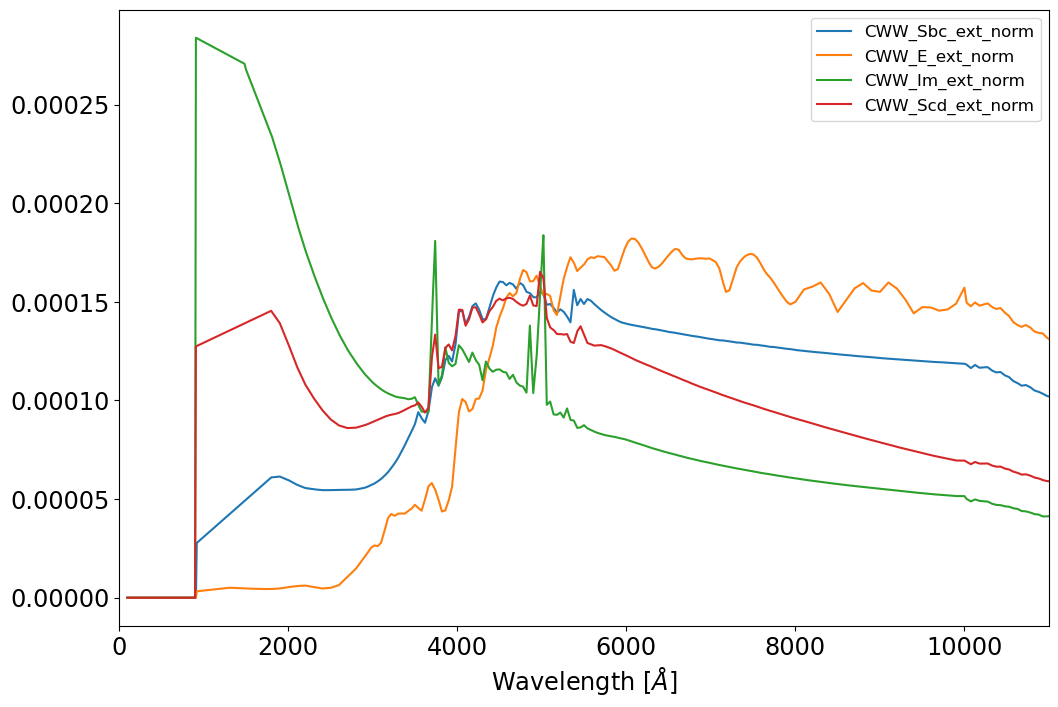

In [16]:
f,a = plt.subplots(1,1)
df_cww_spec_normed_noELG.plot('Wavelength', df_cww_spec_normed_noELG.keys()[1:], ax=a)
a.set_xlim(0, 11000)
a.set_xlabel("Wavelength [$\AA$]")

In [17]:
df_fors2SL_noELG_prop = pd.DataFrame(index=all_numbers)
df_fors2SL_noELG_prop["File"] = [os.path.join(path_BC, f'SPEC{_num}_HZ4_BC.txt') for _num in all_numbers]
df_fors2SL_noELG_prop["Spectrum"] = [f'SPEC{_num}_HZ4_BC' for _num in all_numbers]
df_fors2SL_noELG_prop["Normalized spectrum"] = [f'SPEC{_num}_HZ4_BC_norm' for _num in all_numbers]
df_fors2SL_noELG_prop["Redshift"] = [ t[t['ID']==_num]['z'][0] for _num in all_numbers ]

for band in mag_list:
    df_fors2SL_noELG_prop[f"M_{band}"] = [ mag_in_band(df_fors2SL_spec_normed["Wavelength"],\
                                                       df_fors2SL_spec_normed[_spec],\
                                                       rect_bands_dict[band])\
                                          for _spec in df_fors2SL_noELG_prop["Normalized spectrum"] ]
    
for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
    df_fors2SL_noELG_prop[f"{_c1}-{_c2}"] = df_fors2SL_noELG_prop[f"M_{_c1}"]-df_fors2SL_noELG_prop[f"M_{_c2}"]


all_d4000n = np.array([])
for _specN in df_fors2SL_noELG_prop["Normalized spectrum"]:
    wls = df_fors2SL_spec_normed["Wavelength"]
    lums = df_fors2SL_spec_normed[_specN]
    _selm = (wls >= l1m) * (wls <= l2m)
    _selp = (wls >= l1p) * (wls <= l2p)
    d_4000n = np.trapz(lums[_selp], x=wls[_selp]) / np.trapz(lums[_selm], x=wls[_selm])
    all_d4000n = np.append(all_d4000n, d_4000n)

df_fors2SL_noELG_prop["D4000n"] = all_d4000n

for _cww in df_cww_spec_normed_noELG.keys()[1:]:
    col_UB_cww = color_index(df_cww_spec_normed_noELG['Wavelength'], df_cww_spec_normed_noELG[_cww], rect_bands_dict['U'], rect_bands_dict['B'])
    col_BV_cww = color_index(df_cww_spec_normed_noELG['Wavelength'], df_cww_spec_normed_noELG[_cww], rect_bands_dict['B'], rect_bands_dict['V'])
    col_VR_cww = color_index(df_cww_spec_normed_noELG['Wavelength'], df_cww_spec_normed_noELG[_cww], rect_bands_dict['V'], rect_bands_dict['R'])
    col_RI_cww = color_index(df_cww_spec_normed_noELG['Wavelength'], df_cww_spec_normed_noELG[_cww], rect_bands_dict['R'], rect_bands_dict['I'])
    kin_name = "_".join(_cww.split('_')[:2])
    
    df_fors2SL_noELG_prop[f"Color-distance to {kin_name}"] = dist_color(df_fors2SL_noELG_prop['U-B'],\
                                                                        df_fors2SL_noELG_prop['B-V'],\
                                                                        df_fors2SL_noELG_prop['V-R'],\
                                                                        df_fors2SL_noELG_prop['R-I'],\
                                                                        col_UB_cww,\
                                                                        col_BV_cww,\
                                                                        col_VR_cww,\
                                                                        col_RI_cww\
                                                                       )    

mydict = {}
for _cww in df_cww_spec_normed_noELG.keys()[1:]:
    mydict[_cww] = []

colorNeighbour=True

if colorNeighbour:
    for _num in all_numbers:
        _sed = f"SPEC{_num}_HZ4_BC_norm"
        nearest = df_cww_spec_normed_noELG.keys()[1]
        kin_name = "_".join(nearest.split('_')[:2])
        dist = df_fors2SL_noELG_prop.loc[_num, f"Color-distance to {kin_name}"]
        #print(dist)

        for _cww in df_cww_spec_normed_noELG.keys()[2:]:
            kin_name = "_".join(_cww.split('_')[:2])
            _dist = df_fors2SL_noELG_prop.loc[_num, f"Color-distance to {kin_name}"]
            if _dist < dist:
                nearest = _cww
                dist = _dist
        mydict[nearest].append(_num)
        df_fors2SL_noELG_prop.loc[_num, "Nearest ref"] = nearest
else:
    for _num in all_numbers:
        _sed = f"SPEC{_num}_HZ4_BC_norm"
        nearest = df_cww_spec_normed_noELG.keys()[1]
        _wl = df_fors2SL_spec_normed['Wavelength']
        dist = abs(dist_spec(df_fors2SL_spec_normed[_sed], df_cww_spec_normed_noELG[nearest],\
                             _wl, KL_div=False))
        for _cww in df_cww_spec_normed_noELG.keys()[2:]:
            _dist = abs(dist_spec(df_fors2SL_spec_normed[_sed], df_cww_spec_normed_noELG[_cww],\
                                  _wl, KL_div=False))
            if _dist < dist:
                nearest = _cww
                dist = _dist
        mydict[nearest].append(_num)
        df_fors2SL_noELG_prop.loc[_num, "Nearest ref"] = nearest

dict_to_save = {}
for key in mydict.keys():
    if len(mydict[key]) > 0:
        new_key = "CLUST_"+"_".join(key.split("_")[:-1])
        dict_to_save[new_key] = mydict[key]
print(dict_to_save)

{'CLUST_CWW_Sbc_ext': [2, 19, 24, 30, 31, 34, 37, 47, 57, 58, 69, 132, 149, 178, 181, 183, 192, 197, 221, 226, 227, 234, 236, 238, 244, 252, 258, 274, 275, 280, 281, 287, 292, 296, 301, 323, 329, 338, 339, 353, 361, 364, 372, 375, 382, 383, 384, 389, 392, 393, 394, 400, 401, 402, 406, 407, 418, 425, 427, 439, 441, 442, 446, 447, 451, 452, 453, 455, 456, 457, 460, 462, 469, 475, 476, 477, 478, 479, 481, 496, 497, 500, 507, 508, 512, 516, 517, 527, 533, 539, 540, 542, 550, 552, 562, 563, 567, 569, 571, 574, 578, 579, 580, 586, 588, 589, 596, 601, 610, 621, 623, 625, 628, 630, 634, 636, 638, 650, 652, 655, 658, 659, 660, 672, 673, 676, 679, 680, 689, 690, 692, 695, 696, 700, 702, 703, 705, 706, 714, 726, 729], 'CLUST_CWW_E_ext': [9, 33, 35, 55, 62, 71, 118, 137, 141, 171, 179, 182, 186, 188, 189, 193, 198, 218, 222, 223, 231, 233, 235, 271, 277, 278, 282, 288, 303, 304, 318, 321, 324, 334, 335, 343, 349, 351, 355, 358, 359, 362, 376, 378, 379, 381, 387, 391, 398, 404, 410, 412, 417, 429, 

In [18]:
clus_dict = dict_to_save

avg_clus_dict = {}
avg_clus_dict_normed = {}
df_avg_spec = pd.DataFrame()
df_avg_spec_normed = pd.DataFrame()
df_avg_spec['Wavelength'] = lambdas
df_avg_spec_normed['Wavelength'] = lambdas
new_clus_dict={}
avg_zs = np.empty_like([])
sigma_zs = np.empty_like([])
for key in clus_dict:
    Nspec = len(clus_dict[key])
    if Nspec > 0:
        _dict = {}
        _dict['ID'] = clus_dict[key]
        _redshifts = np.empty_like([])
        _spec_arr = np.zeros_like(lambdas)
        _normSpec_arr = np.zeros_like(lambdas)
        for spec_id in clus_dict[key]:
            _spec = df_fors2SL_noELG_prop.loc[spec_id, "Spectrum"]
            _specN = df_fors2SL_noELG_prop.loc[spec_id, "Normalized spectrum"]
            _z = df_fors2SL_noELG_prop.loc[spec_id, "Redshift"]
            lumins = df_fors2SL_spec[_spec]
            normed_spec = df_fors2SL_spec_normed[_specN]
            _redshifts = np.append(_redshifts, _z)
            _spec_arr = np.column_stack((_spec_arr, lumins))
            _normSpec_arr = np.column_stack((_normSpec_arr, normed_spec))
        _dict['z_s'] = _redshifts.tolist()
        new_clus_dict[key] = _dict
        _avg_z = np.mean(_redshifts)
        avg_zs = np.append(avg_zs, _avg_z)
        _sigma_z = np.std(_redshifts)
        sigma_zs = np.append(sigma_zs, _sigma_z)
        _spec_arr = _spec_arr[:,1:]
        _normSpec_arr = _normSpec_arr[:,1:]
        avg_spec = np.mean(_spec_arr, axis=1, dtype=np.float64)
        sigma_spec = np.std(_spec_arr, axis=1, dtype=np.float64)
        avg_normed_spec = np.mean(_normSpec_arr, axis=1, dtype=np.float64)
        sigma_normed_spec = np.std(_normSpec_arr, axis=1, dtype=np.float64)
        avg_clus_dict[f'AVG_{key}'] = np.column_stack((lambdas, avg_spec))
        avg_clus_dict_normed[f'AVG_{key}_normed'] = np.column_stack((lambdas, avg_normed_spec))
        df_avg_spec[f'AVG_{key}'] = avg_spec
        df_avg_spec[f'SIG_{key}'] = sigma_spec
        df_avg_spec_normed[f'AVG_{key}_normed'] = avg_normed_spec
        df_avg_spec_normed[f'SIG_{key}_normed'] = sigma_normed_spec

In [19]:
refs_arr = np.array(sorted(df_cww_spec_normed_noELG.keys()[1:]))
templates_arr = np.array(list(clus_dict.keys()))
print(templates_arr)
kinCal_refs = [ "_".join(temp.split('_')[1:])+'_norm' for temp in templates_arr ]
df_refs_dist_noELG = pd.DataFrame(index=templates_arr)
df_refs_dist_noELG['N_FORS2'] = [len(clus_dict[key]) for key in clus_dict]
df_refs_dist_noELG['Template_label'] = [f'AVG_{key}_normed' for key in clus_dict]
df_refs_dist_noELG['avg_z'] = avg_zs
df_refs_dist_noELG['sigma_z'] = sigma_zs
df_refs_dist_noELG['Ref_CWW_Kin_SED'] = kinCal_refs

for band in mag_list:
    df_refs_dist_noELG[f"M_{band}"] = [ mag_in_band(df_avg_spec_normed["Wavelength"], df_avg_spec_normed[_spec],\
                                                    rect_bands_dict[band])\
                                       for _spec in df_refs_dist_noELG["Template_label"] ]
    
for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
    df_refs_dist_noELG[f"{_c1}-{_c2}"] = df_refs_dist_noELG[f"M_{_c1}"]-df_refs_dist_noELG[f"M_{_c2}"]

for key in df_refs_dist_noELG.index:
    ref_SED = df_refs_dist_noELG.loc[key, 'Ref_CWW_Kin_SED']
    kin_name = "_".join(ref_SED.split('_')[:2])
    _dists_to_ref = np.empty_like([])
    for spec_id in clus_dict[key]:
        _specN = df_fors2SL_noELG_prop.loc[spec_id, "Normalized spectrum"]
        normed_spec = df_fors2SL_spec_normed[_specN]
        if colorNeighbour:
            _dist = df_fors2SL_noELG_prop.loc[spec_id, f"Color-distance to {kin_name}"]
        else:
            _dist = dist_spec(normed_spec, df_cww_spec_normed_noELG[ref_SED], lambdas=lambdas, KL_div=False)
        _dists_to_ref = np.append(_dists_to_ref, _dist)
    _avg_dist_to_ref = np.mean(_dists_to_ref)
    _sigma_dist_to_ref = np.std(_dists_to_ref)
    df_refs_dist_noELG.loc[key, 'Avg_dist_to_ref_SED'] = _avg_dist_to_ref
    df_refs_dist_noELG.loc[key, 'Sigma_ref_SED'] = _sigma_dist_to_ref

df_refs_dist_noELG

['CLUST_CWW_Sbc_ext' 'CLUST_CWW_E_ext' 'CLUST_CWW_Im_ext'
 'CLUST_CWW_Scd_ext']


,N_FORS2,Template_label,avg_z,sigma_z,Ref_CWW_Kin_SED,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I,Avg_dist_to_ref_SED,Sigma_ref_SED
CLUST_CWW_Sbc_ext,141,AVG_CLUST_CWW_Sbc_ext_normed,0.469909,0.277967,CWW_Sbc_ext_norm,7.566390,7.082851,6.550633,5.630715,4.946214,0.483539,0.532218,0.919918,0.684502,0.221872,0.098523
CLUST_CWW_E_ext,113,AVG_CLUST_CWW_E_ext_normed,0.444272,0.177128,CWW_E_ext_norm,7.783733,7.002822,6.283392,5.285758,4.530616,0.780911,0.719430,0.997634,0.755142,0.221737,0.086103
CLUST_CWW_Im_ext,145,AVG_CLUST_CWW_Im_ext_normed,0.503805,0.291989,CWW_Im_ext_norm,7.590822,7.629452,7.476120,6.743054,6.196362,-0.038630,0.153332,0.733067,0.546692,0.237626,0.119715
CLUST_CWW_Scd_ext,142,AVG_CLUST_CWW_Scd_ext_normed,0.526220,0.231340,CWW_Scd_ext_norm,7.379227,7.126352,6.803168,5.995910,5.425510,0.252875,0.323184,0.807258,0.570400,0.154249,0.071301


31
62


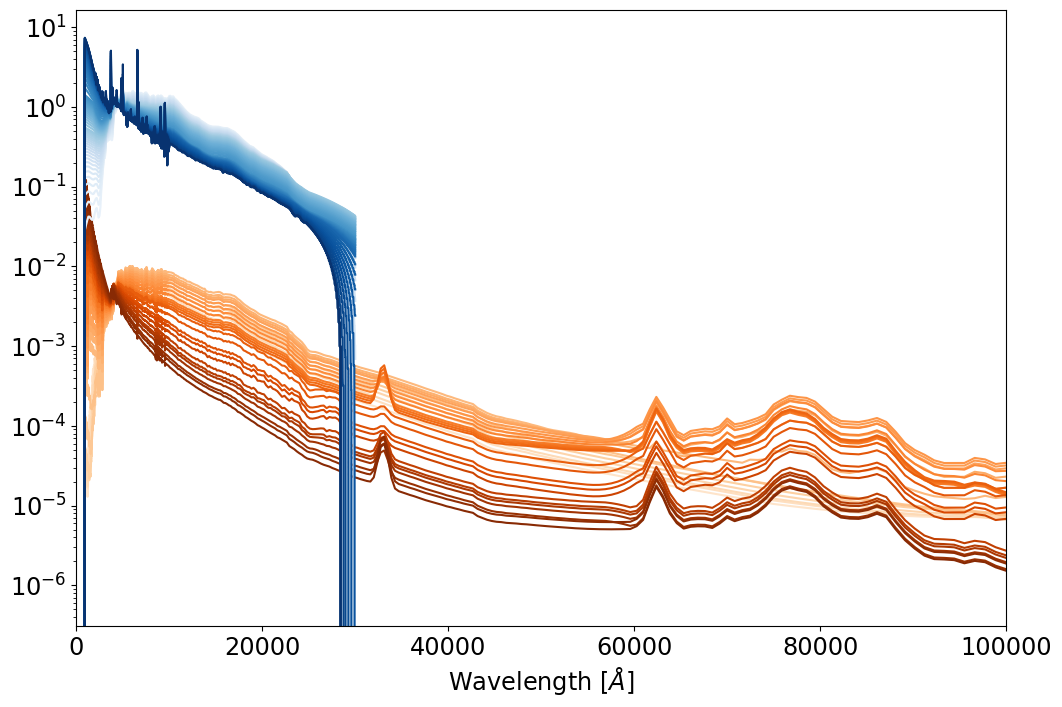

In [20]:
vista_list_file = "COSMOS_MOD.list" # CFHTLS_MOD.list
vista_dir = "COSMOS_SED" # CFHTLS_230506
with open(os.path.join(LEPHAREDIR, 'sed/GAL', vista_dir, vista_list_file),'r') as _f:
    _seds_list = _f.readlines()
paths_to_vistas = [os.path.join(LEPHAREDIR, 'sed/GAL', _sed.split(" ")[0]) for _sed in _seds_list]
print(len(paths_to_vistas))

oranges = plt.get_cmap('Oranges')
oraNorm = colors.Normalize(vmin=-5, vmax=len(paths_to_vistas))
oraMap = cmx.ScalarMappable(norm=oraNorm, cmap=oranges)

all_oranges = oraMap.to_rgba(np.arange(len(paths_to_vistas)), alpha=1)

for (_sed, col) in zip(paths_to_vistas, all_oranges):
    sed_arr = np.loadtxt(_sed)
    plt.plot(sed_arr[:, 0], sed_arr[:, 1], color=col)
    plt.xlim(0., 100000.)
    plt.yscale('log')
    

cfh_list_file = "CFHTLS_MOD.list"
cfh_dir = "CFHTLS_230506"
with open(os.path.join(LEPHAREDIR, 'sed/GAL', cfh_dir, cfh_list_file),'r') as _f:
    _seds_list = _f.readlines()
paths_to_cfhs = [os.path.join(LEPHAREDIR, 'sed/GAL', _sed.split(" ")[0]) for _sed in _seds_list]
print(len(paths_to_cfhs))

blues = plt.get_cmap('Blues')
bluNorm = colors.Normalize(vmin=-5, vmax=len(paths_to_cfhs))
bluMap = cmx.ScalarMappable(norm=bluNorm, cmap=blues)

all_blues = bluMap.to_rgba(np.arange(len(paths_to_cfhs)), alpha=1)

for (_sed, col) in zip(paths_to_cfhs, all_blues):
    sed_arr = np.loadtxt(_sed)
    plt.plot(sed_arr[:, 0], sed_arr[:, 1], color=col)
    plt.yscale('log')
    plt.xlabel('Wavelength [$\AA$]')

-0.0006 1.0


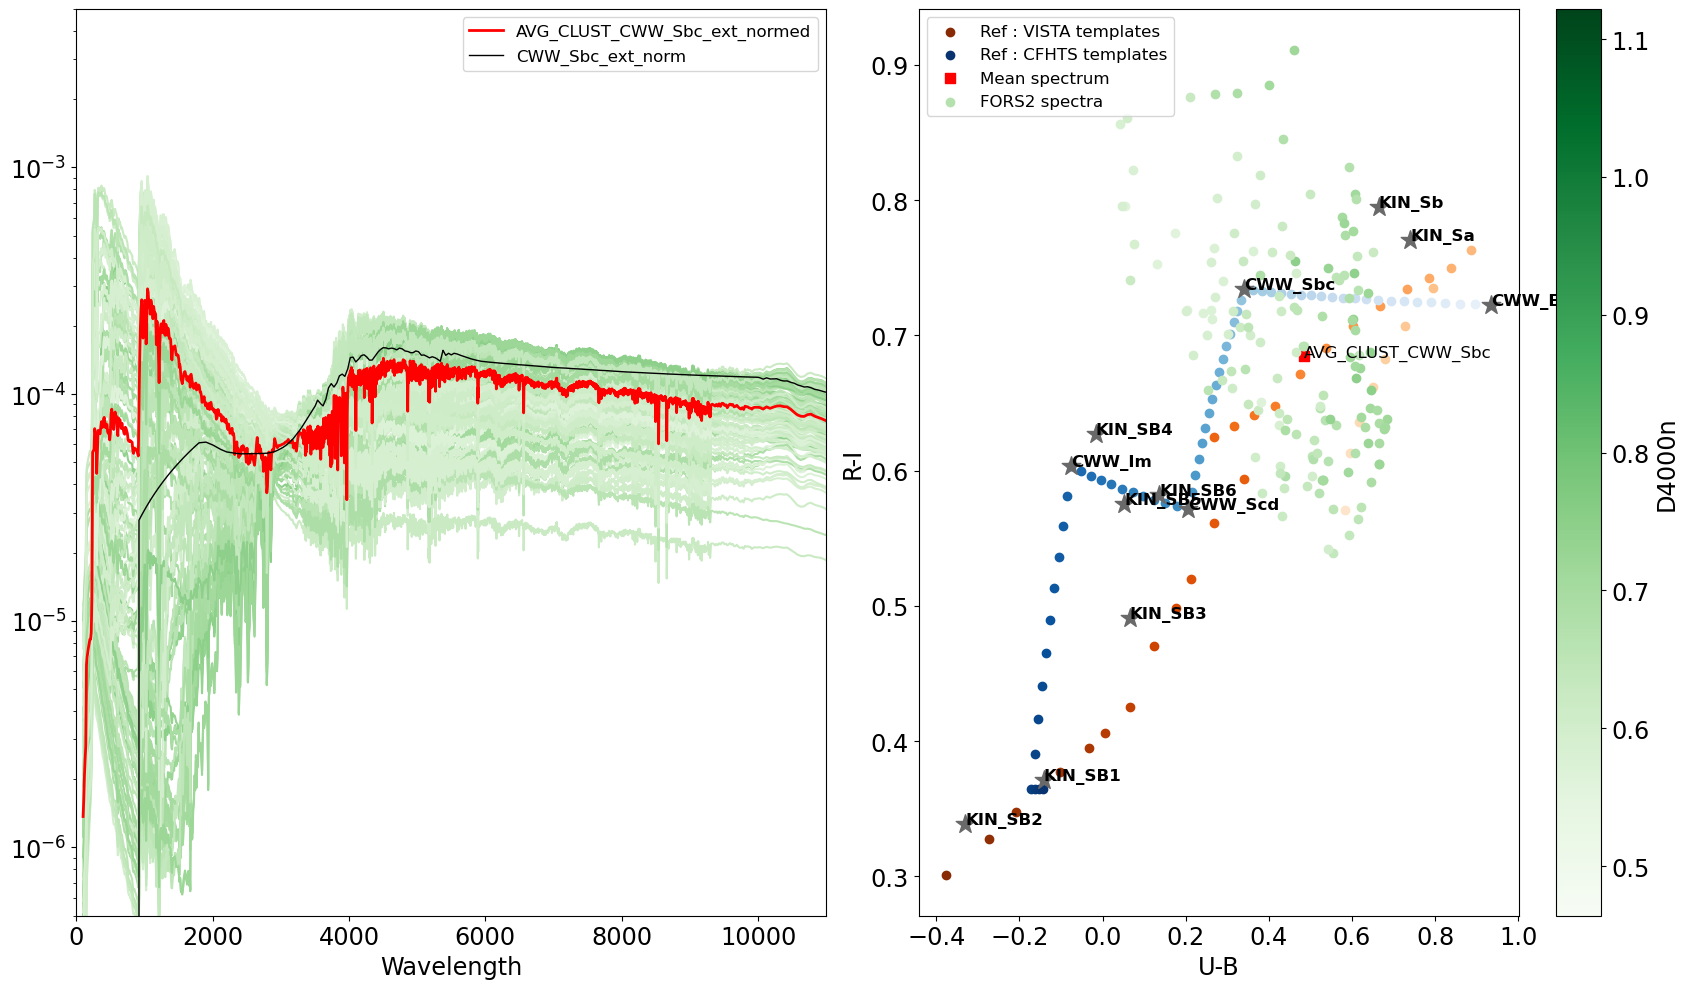

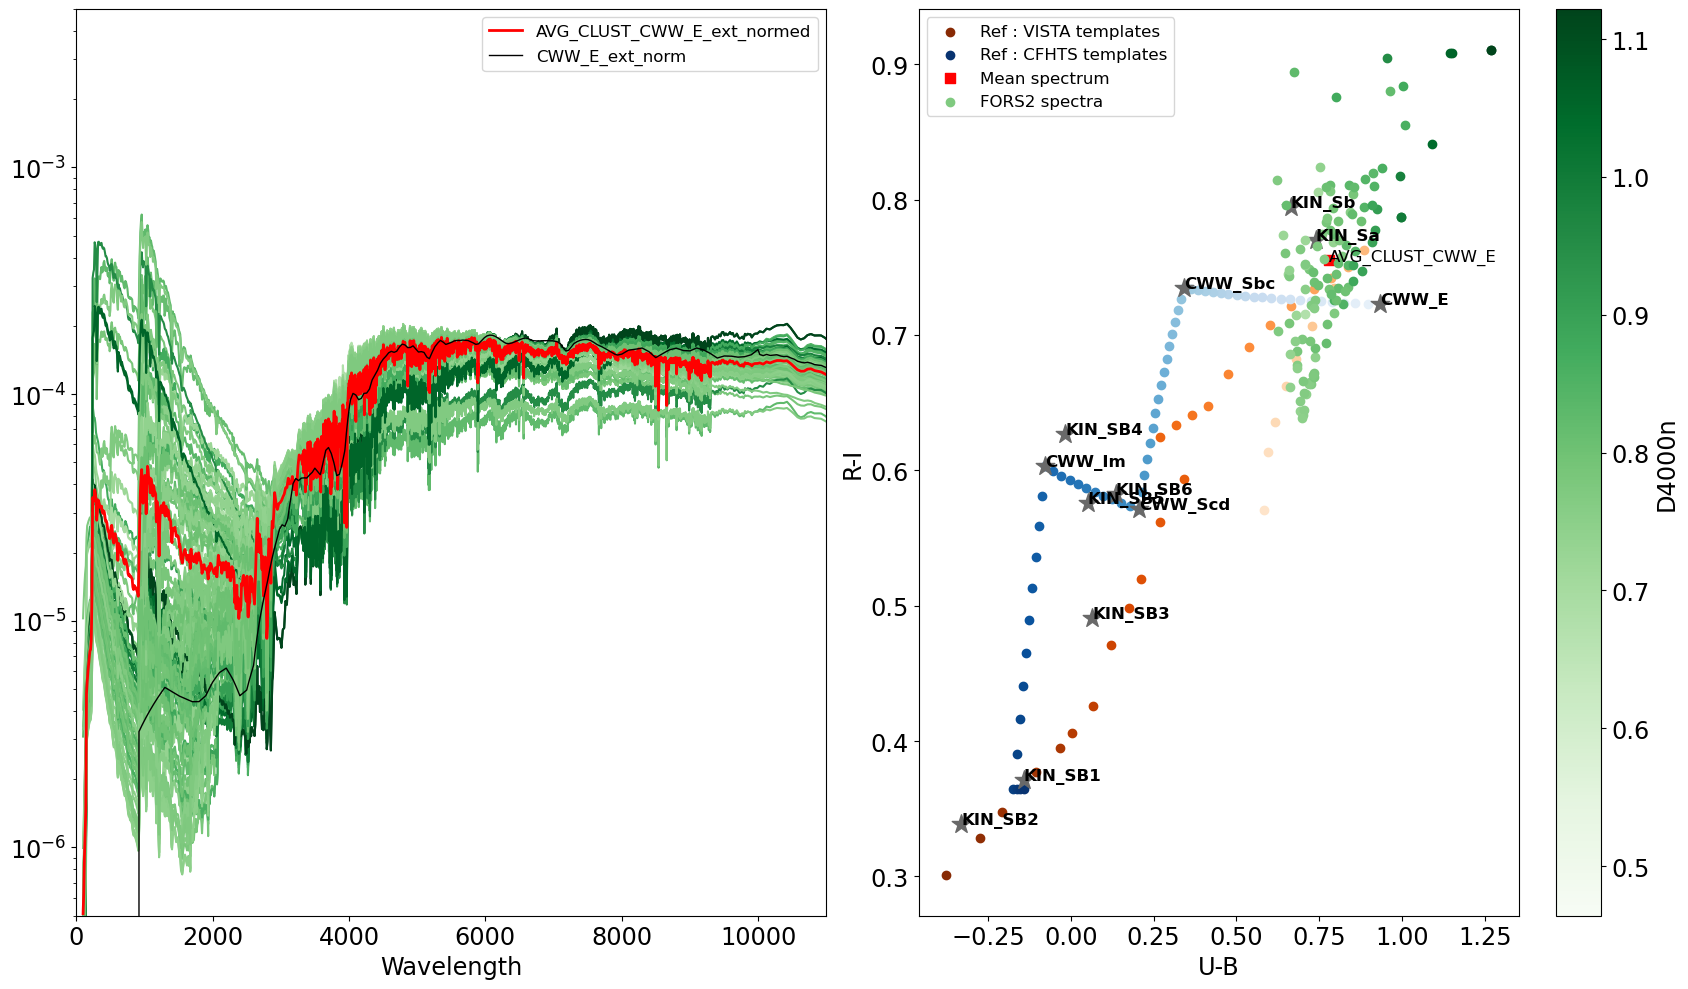

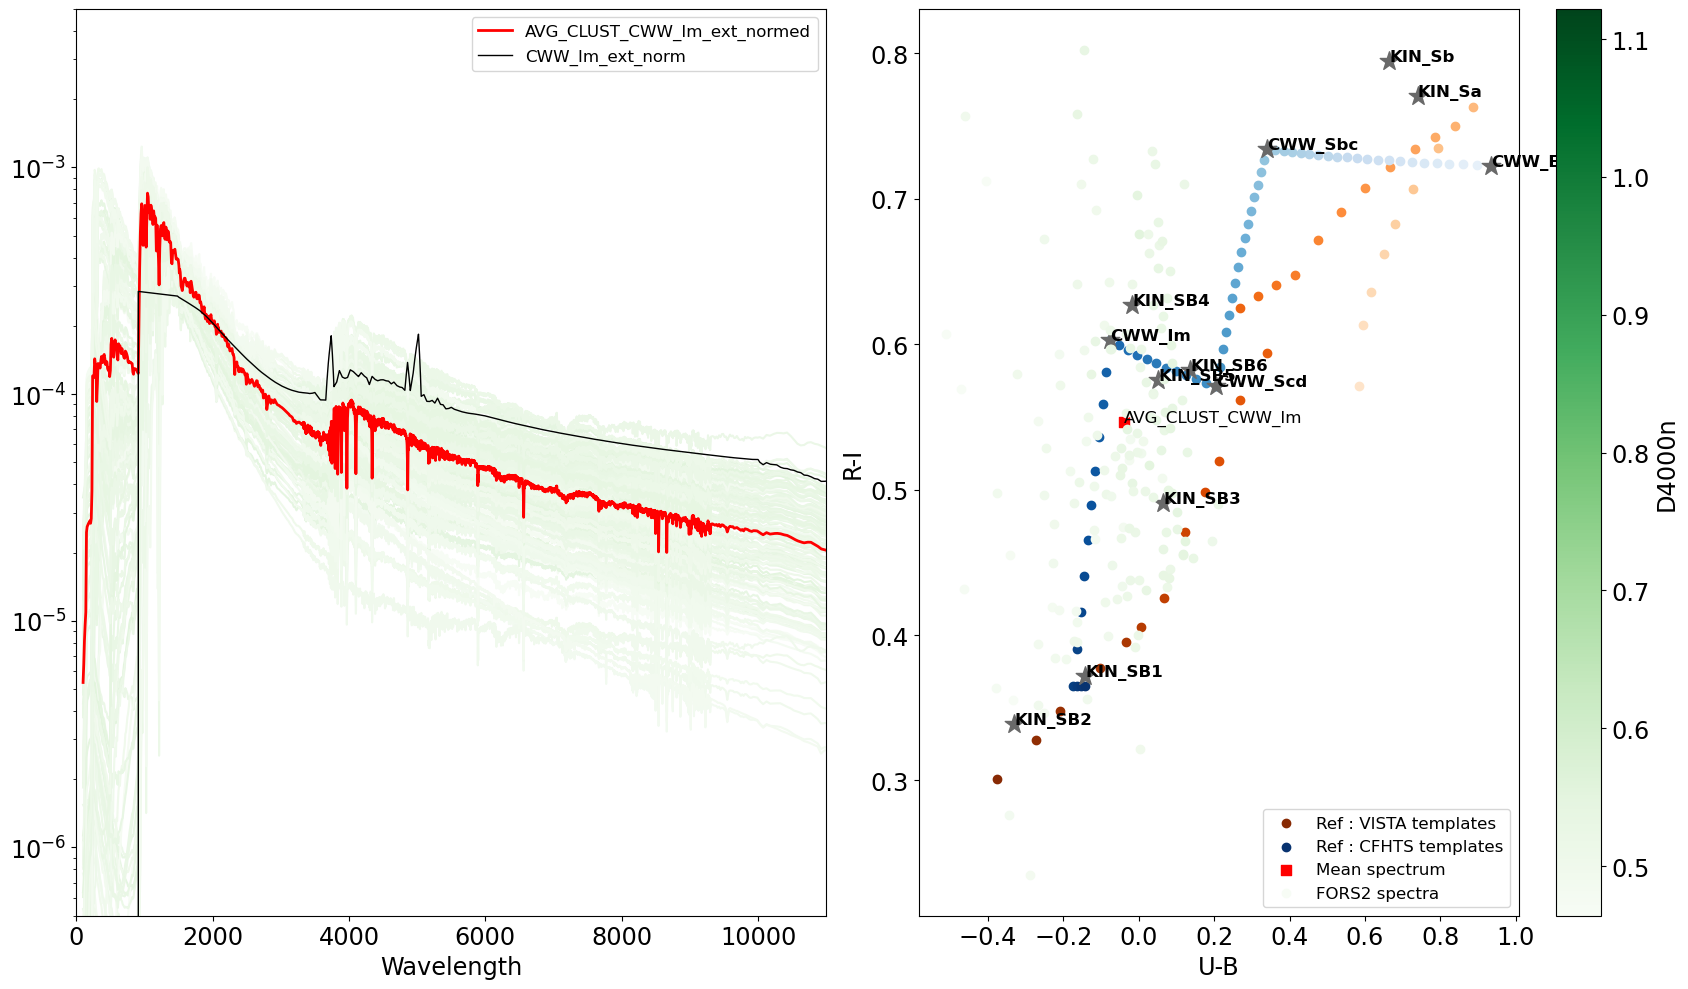

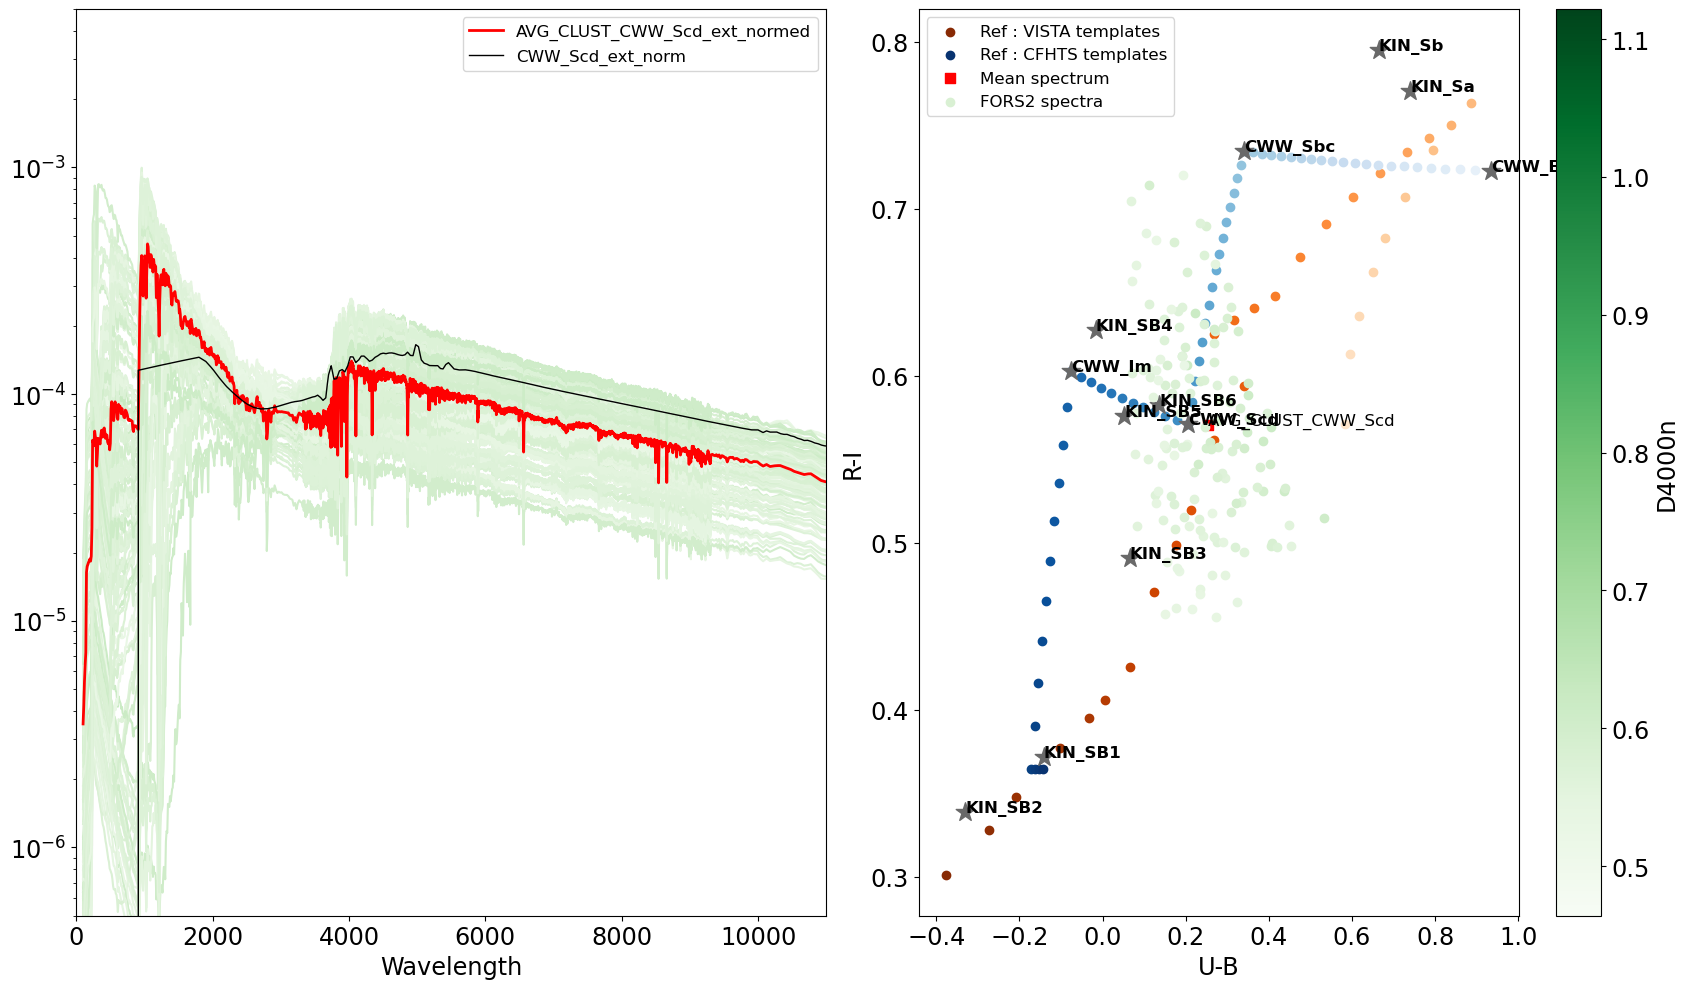

In [21]:
z_min, z_max = 1., 0.
for key in df_refs_dist_noELG.index:
    _dict = new_clus_dict[key]
    _redshifts = _dict['z_s']
    _z_min, _z_max = np.amin(_redshifts), np.amax(_redshifts)
    z_min, z_max = min(z_min, _z_min), max(z_max, _z_max)
    z_max = min(1.0, z_max)
print(z_min, z_max)

blu_red = plt.get_cmap('Greens')
cNorm = colors.Normalize(vmin=min(df_fors2SL_noELG_prop["D4000n"].values), vmax=max(df_fors2SL_noELG_prop["D4000n"].values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=blu_red)
    
_c1, _c2, _c3, _c4 = 'U', 'B', 'R', 'I'

all_figs_fors2_noELG=[]
for key in df_refs_dist_noELG.index:
    f, a = plt.subplots(1,2, figsize=(17,10))
    a=a.ravel()

    for _sed, col, num in zip(paths_to_vistas, all_oranges, np.arange(len(paths_to_vistas))):
        _spec_arr = np.loadtxt(_sed)
        _spec_fonc = interp1d(_spec_arr[:-1, 0], _spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
        _lumins = _spec_fonc(lambdas)
        _norm = np.trapz(_lumins[mask], lambdas[mask])
        normed_spec = _lumins/_norm
        col_UB = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c3], rect_bands_dict[_c4])
        lab=''
        if num==len(paths_to_vistas)-1 : lab='Ref : VISTA templates'
        a[1].scatter(col_UB, col_BV, color=col, label=lab)

    for _sed, col, num in zip(paths_to_cfhs, all_blues, np.arange(len(paths_to_cfhs))):
        _spec_arr = np.loadtxt(_sed)
        _spec_fonc = interp1d(_spec_arr[:-1, 0], _spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
        _lumins = _spec_fonc(lambdas)
        _norm = np.trapz(_lumins[mask], lambdas[mask])
        normed_spec = _lumins/_norm
        col_UB = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c3], rect_bands_dict[_c4])
        lab=''
        if num==len(paths_to_cfhs)-1 : lab='Ref : CFHTS templates'
        a[1].scatter(col_UB, col_BV, color=col, label=lab)
        
    for kin_sed in df_cww_spec_normed.columns[1:]:
        col_UB_cww = color_index(lambdas[mask], df_cww_spec_normed[kin_sed][mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV_cww = color_index(lambdas[mask], df_cww_spec_normed[kin_sed][mask], rect_bands_dict[_c3], rect_bands_dict[_c4])

        kin_name = "_".join(kin_sed.split('_')[:2])

        a[1].scatter(col_UB_cww, col_BV_cww, color='dimgray', s=196, marker="*")
        a[1].annotate(kin_name, (col_UB_cww, col_BV_cww), fontsize=12, weight='bold')

    #a.legend(loc='lower left', bbox_to_anchor=(1., 0.))
    
    nearest_SED = df_refs_dist_noELG.loc[key, 'Ref_CWW_Kin_SED']
    avg_spec = df_refs_dist_noELG.loc[key, 'Template_label']
    
    col_UB_avg = color_index(lambdas[mask], df_avg_spec_normed[avg_spec][mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
    col_BV_avg = color_index(lambdas[mask], df_avg_spec_normed[avg_spec][mask], rect_bands_dict[_c3], rect_bands_dict[_c4])

    sl_num = "_".join(avg_spec.split('_')[0:-2])
    lab='Mean spectrum'
    a[1].scatter(col_UB_avg, col_BV_avg, color='red', marker='s', s=49, label=lab)
    a[1].annotate(sl_num, (col_UB_avg, col_BV_avg), fontsize=12)
    
    _dict = new_clus_dict[key]
    dict_cluster, dict_cluster_n = {}, {}
    dict_cluster['Wavelength'] = lambdas
    dict_cluster_n['Wavelength'] = lambdas
    
    _all_d4000n = np.array([])
    
    _redshifts = _dict['z_s']
    all_colors = scalarMap.to_rgba(_all_d4000n, alpha=1)
    for num, _fors2spec in enumerate(_dict['ID']):
        _spec = df_fors2SL_noELG_prop.loc[_fors2spec, "Spectrum"]
        _specN = df_fors2SL_noELG_prop.loc[_fors2spec, "Normalized spectrum"]
        spec = df_fors2SL_spec[_spec]
        normed_spec = df_fors2SL_spec_normed[_specN]

        d_4000n = df_fors2SL_noELG_prop.loc[_fors2spec, "D4000n"]
        _all_d4000n = np.append(_all_d4000n, d_4000n)
        
        dict_cluster[f'SPEC{_fors2spec}'] = spec
        dict_cluster_n[f'SPEC{_fors2spec}'] = normed_spec
        
        col_UB_extr = df_fors2SL_noELG_prop.loc[_fors2spec, f"{_c1}-{_c2}"]
        col_BV_extr = df_fors2SL_noELG_prop.loc[_fors2spec, f"{_c3}-{_c4}"]

        lab=''
        if num==0 : lab='FORS2 spectra'
        a[1].scatter(col_UB_extr, col_BV_extr, color=scalarMap.to_rgba(d_4000n, alpha=1), label=lab)
        
    _listPlots = [f'SPEC{_fors2spec}' for _fors2spec in _dict['ID']]
    
    all_colors = scalarMap.to_rgba(_all_d4000n, alpha=1)
    df_cluster = pd.DataFrame(dict_cluster)
    df_cluster_n = pd.DataFrame(dict_cluster_n)
    df_cluster_n.plot('Wavelength', _listPlots, color=all_colors, ax=a[0], legend=False)
    
    
    df_avg_spec_normed.plot('Wavelength', avg_spec,\
                            color='red', linewidth=2,\
                            ax=a[0])
    df_cww_spec_normed_noELG.plot('Wavelength', nearest_SED, ax=a[0], color='k', linewidth=1)
    

    #a.legend(loc='lower left', bbox_to_anchor=(1., 0.))
    a[0].set_xlim(0., 11000.)
    a[0].set_ylim(5.0e-7, 5.0e-3)
    a[0].set_yscale('log')
    a[1].set_xlabel(f"{_c1}-{_c2}")
    a[1].set_ylabel(f"{_c3}-{_c4}")
    #a[1].set_title(f"Color-color diagram for several sets of galaxies templates")
    a[1].legend()
    plt.colorbar(scalarMap, location='right', label='D4000n', ax=a[1])
    f.set_tight_layout(True)
    all_figs_fors2_noELG.append(f)
    
    
    sed_type = '-'.join(key.split('_')[1:3])
    _gal_seds = f'FORS2_forFixedZ_{sed_type}_batch1'
    sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
    if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
    list_file_name = f'FORS2_forFixedZ_{sed_type}_v1'
    
    #print(os.listdir(sed_dir))

    if False:
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
            #_l.write(f'# FORS2-derived templates using K-mean clustering in {n_clu} groups from which an average and two extrema were selected\n')
            _l.write(f'# FORS2-derived templates using clustering around {sed_type} without ELG from which all SEDs were selected to be used with ZFIX option in LEPHARE.\n')
        for _sedId in dict_cluster:
            if _sedId != "Wavelength":
                _arr = np.column_stack((dict_cluster["Wavelength"], dict_cluster[_sedId]))
                np.savetxt(os.path.join(sed_dir,f'{_sedId}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
                with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                    _l.write(_gal_seds+f'/{_sedId}.sed\n')

    if False:
        list_file_name = list_file_name+'_normed'
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
            #_l.write(f'# FORS2-derived templates using K-mean clustering in {n_clu} groups from which an average and two extrema were selected. Normalised by the integral between 1000 and 10000 angstrom.\n')
            _l.write(f'# FORS2-derived templates using clustering around {sed_type} without ELG from which all SEDs were selected to be used with ZFIX option in LEPHARE. Normalised by the integral between {lambdaMin} and {lambdaMax} angstrom.\n')
        for _sedId in dict_cluster_n:
            if _sedId != "Wavelength":
                _arr = np.column_stack((dict_cluster_n["Wavelength"], dict_cluster_n[_sedId]))
                np.savetxt(os.path.join(sed_dir,f'{_sedId}n.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
                with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                    _l.write(_gal_seds+f'/{_sedId}n.sed\n')

In [22]:
df_fors2SL_noELG_prop

,File,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I,D4000n,Color-distance to CWW_Sbc,Color-distance to CWW_E,Color-distance to CWW_Im,Color-distance to CWW_Scd,Nearest ref
2,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC2_HZ4_BC,SPEC2_HZ4_BC_norm,0.34555,7.841186,7.248528,6.575336,5.553558,4.729059,0.592659,0.673191,1.021778,0.824499,0.670034,0.337586,0.378350,0.863927,0.563574,CWW_Sbc_ext_norm
3,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC3_HZ4_BC,SPEC3_HZ4_BC_norm,0.68660,7.123839,6.745418,6.413098,5.615124,5.069929,0.378421,0.332320,0.797974,0.545195,0.580588,0.279656,0.786726,0.473019,0.193821,CWW_Scd_ext_norm
9,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC9_HZ4_BC,SPEC9_HZ4_BC_norm,0.29266,7.734871,7.041544,6.332464,5.326814,4.563518,0.693327,0.709081,1.005650,0.763296,0.770543,0.422760,0.263468,0.946313,0.627546,CWW_E_ext_norm
13,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC13_HZ4_BC,SPEC13_HZ4_BC_norm,0.68870,7.528007,7.998384,8.092526,7.506569,6.937235,-0.470377,-0.094142,0.585958,0.569334,0.464858,1.069072,1.733379,0.553897,0.878506,CWW_Im_ext_norm
19,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC19_HZ4_BC,SPEC19_HZ4_BC_norm,0.48395,7.462731,6.998107,6.537564,5.621109,4.874679,0.464624,0.460543,0.916455,0.746430,0.594247,0.128218,0.592847,0.618262,0.324956,CWW_Sbc_ext_norm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC734_HZ4_BC,SPEC734_HZ4_BC_norm,0.23012,7.997627,7.885585,7.520270,6.670018,6.027174,0.112042,0.365315,0.850252,0.642843,0.565484,0.286731,0.952980,0.245147,0.123519,CWW_Scd_ext_norm
735,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC735_HZ4_BC,SPEC735_HZ4_BC_norm,0.36169,7.561457,6.829766,6.175416,5.234653,4.564349,0.731691,0.654349,0.940763,0.670304,0.773303,0.427915,0.275452,0.929395,0.598894,CWW_E_ext_norm
736,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC736_HZ4_BC,SPEC736_HZ4_BC_norm,0.55777,7.503118,7.621814,7.505943,6.794347,6.291662,-0.118695,0.115871,0.711596,0.502685,0.503431,0.671790,1.316987,0.182416,0.458524,CWW_Im_ext_norm
737,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC737_HZ4_BC,SPEC737_HZ4_BC_norm,0.52001,7.235184,6.849328,6.424852,5.582614,5.021923,0.385856,0.424476,0.842238,0.560691,0.611247,0.207707,0.712967,0.508908,0.181571,CWW_Scd_ext_norm


In [24]:
if True:
    df_fors2SL_noELG_prop.to_pickle('fors2_properties.pkl')